In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Load the dataset
file_path = '/kaggle/input/fleet-data/fleet_management_large_dataset.csv'
df = pd.read_csv(file_path)

In [6]:
#data preprocessing
print(df.head())


  vehicle_id vehicle_type fuel_type last_service_date route_id       origin  \
0     V00000          Bus    Petrol        2024-06-05   R00000      Chicago   
1     V00001          Car    Diesel        2022-11-16   R00001      Phoenix   
2     V00002        Truck    Petrol        2024-01-21   R00002    San Diego   
3     V00003        Truck    Diesel        2023-03-16   R00003      Phoenix   
4     V00004          Bus  Electric        2024-06-03   R00004  Los Angeles   

   destination  distance_km driver_id         driver_name  experience_years  \
0  Los Angeles      1234.97    D00000     Alexis Campbell                29   
1      Chicago       698.55    D00001          Gina Bryan                23   
2      Houston       216.66    D00002  Mr. Nicholas Clark                 6   
3      Houston      1563.40    D00003         Debra Baker                11   
4    San Diego      1840.68    D00004         Brian Lynch                 1   

  trip_id vehicle_id.1 route_id.1 driver_id.1     

In [7]:
df.shape

(100000, 18)

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_id         100000 non-null  object 
 1   vehicle_type       100000 non-null  object 
 2   fuel_type          100000 non-null  object 
 3   last_service_date  100000 non-null  object 
 4   route_id           100000 non-null  object 
 5   origin             100000 non-null  object 
 6   destination        100000 non-null  object 
 7   distance_km        100000 non-null  float64
 8   driver_id          100000 non-null  object 
 9   driver_name        100000 non-null  object 
 10  experience_years   100000 non-null  int64  
 11  trip_id            100000 non-null  object 
 12  vehicle_id.1       100000 non-null  object 
 13  route_id.1         100000 non-null  object 
 14  driver_id.1        100000 non-null  object 
 15  start_time         100000 non-null  object 
 16  end

In [9]:
df.describe()

,distance_km,experience_years
count,100000.000000,100000.000000
mean,1025.481562,15.493240
std,563.048259,8.658628
min,50.000000,1.000000
25%,536.787500,8.000000
50%,1025.820000,15.000000
75%,1510.920000,23.000000
max,1999.990000,30.000000


In [12]:
def preprocess_data(df):
    # Convert date columns to datetime
    df['last_service_date'] = pd.to_datetime(df['last_service_date'], errors='coerce')
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

    # Drop rows with missing values in critical columns
    df.dropna(subset=['vehicle_id', 'driver_name', 'start_time', 'end_time'], inplace=True)

    # Fill missing values in non-critical columns
    df.fillna({'status': 'Unknown'}, inplace=True)

    # Ensure end_time is after start_time
    df = df[df['end_time'] > df['start_time']]

    # Calculate trip duration in hours
    df.loc[:, 'trip_duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600

    return df


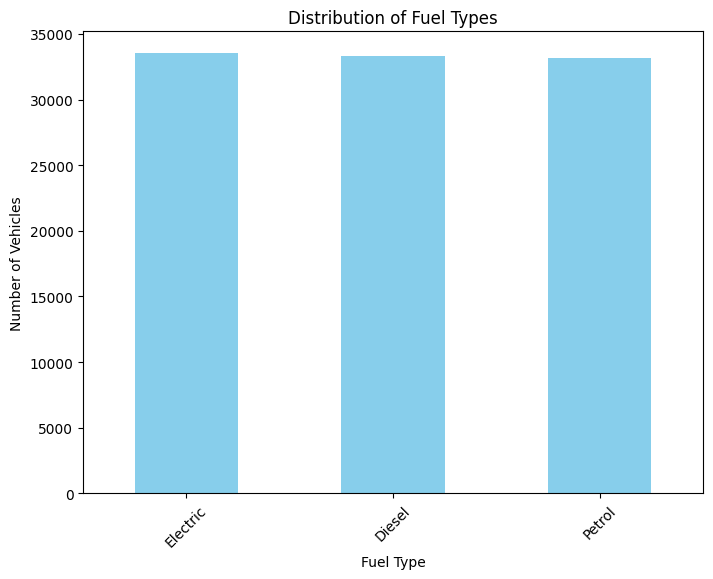

In [13]:
# 1. Distribution of Fuel Types
plt.figure(figsize=(8, 6))
fuel_distribution = df_clean['fuel_type'].value_counts()
fuel_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.show()

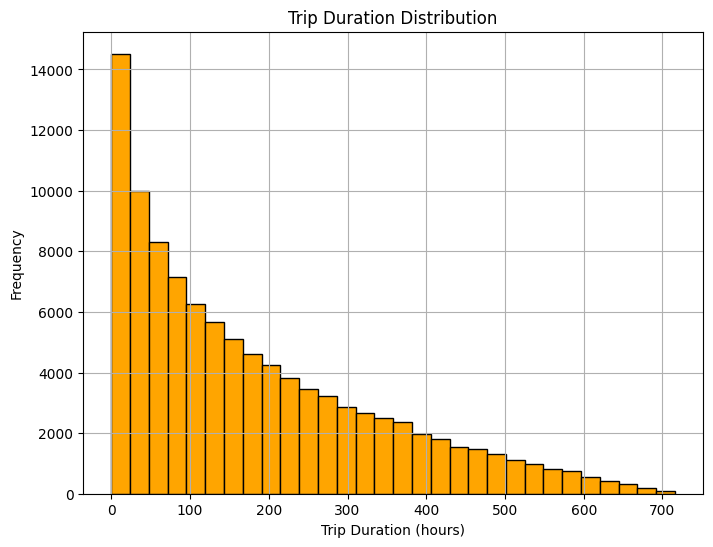

In [14]:
# 2. Trip Duration Histogram
plt.figure(figsize=(8, 6))
plt.hist(df_clean['trip_duration'], bins=30, color='orange', edgecolor='black')
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

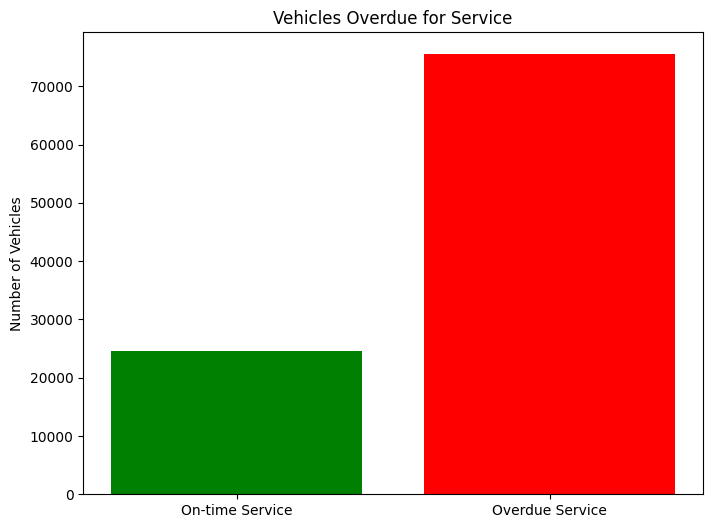

In [16]:
# 3. Service Overdue Vehicles (Assuming a 180-day service rule)
# Calculate days since last service
df_clean.loc[:, 'days_since_service'] = (pd.Timestamp.now() - df_clean['last_service_date']).dt.days

# Count overdue vehicles
overdue_vehicles = df_clean[df_clean['days_since_service'] > 180]['vehicle_id'].nunique()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['On-time Service', 'Overdue Service'], 
        [df_clean['vehicle_id'].nunique() - overdue_vehicles, overdue_vehicles], 
        color=['green', 'red'])
plt.title('Vehicles Overdue for Service')
plt.ylabel('Number of Vehicles')
plt.show()


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import random


In [18]:
# Function to preprocess the dataset
def preprocess_data(df):
    # Convert date columns to datetime format
    df['last_service_date'] = pd.to_datetime(df['last_service_date'])
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # Handle missing or incorrect values
    df.dropna(inplace=True)
    
    # Create a new column to calculate trip duration
    df['trip_duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600  # in hours
    
    # Sort data for better readability (optional)
    df.sort_values(by='start_time', inplace=True)
    
    return df
# Preprocess the data
df_clean = preprocess_data(df)

In [ ]:
# Define the FleetBot class
class FleetBot:
    def __init__(self, df):
        self.df = df
    
    # Track current vehicle trip status
    def track_vehicle(self, vehicle_id):
        vehicle_data = self.df[self.df['vehicle_id'] == vehicle_id]
        if vehicle_data.empty:
            return f"No data found for vehicle ID: {vehicle_id}"
        else:
            current_trip = vehicle_data[vehicle_data['status'] == 'Ongoing']
            if not current_trip.empty:
                trip_info = current_trip.iloc[0]
                return (f"Vehicle {vehicle_id} is currently on a trip from {trip_info['origin']} to {trip_info['destination']} "
                        f"with driver {trip_info['driver_name']}. The trip started at {trip_info['start_time']}.")
            else:
                return f"Vehicle {vehicle_id} is not currently on any trip."
    
    # Check if a vehicle needs maintenance based on last service date
    def check_maintenance(self, vehicle_id):
        vehicle_data = self.df[self.df['vehicle_id'] == vehicle_id]
        if vehicle_data.empty:
            return f"No data found for vehicle ID: {vehicle_id}"
        else:
            last_service = vehicle_data['last_service_date'].max()
            days_since_service = (datetime.now() - last_service).days
            if days_since_service > 180:  # Assuming a vehicle needs service every 180 days
                return f"Vehicle {vehicle_id} needs maintenance. Last service was {days_since_service} days ago."
            else:
                return f"Vehicle {vehicle_id} does not need maintenance. Last service was {days_since_service} days ago."
    
    # Monitor fuel usage and estimate fuel type distribution
    def fuel_report(self):
        fuel_usage = self.df['fuel_type'].value_counts()
        return fuel_usage.to_dict()
    
    # Assign route to a vehicle based on available drivers
    def assign_route(self, vehicle_id, new_route):
        vehicle_data = self.df[self.df['vehicle_id'] == vehicle_id]
        if vehicle_data.empty:
            return f"No data found for vehicle ID: {vehicle_id}"
        
        available_driver = self.df[self.df['status'] != 'Ongoing']['driver_id'].unique()
        if len(available_driver) == 0:
            return "No drivers available for assignment."
        assigned_driver = random.choice(available_driver)
        
        # Simulate the assignment process
        new_trip_id = f"T{len(self.df) + 1:05d}"
        start_time = datetime.now()
        end_time = start_time + timedelta(hours=random.randint(1, 24))  # Random duration for the trip
        
        # Append the new trip to the dataframe (simulation)
        new_trip = {
            'trip_id': new_trip_id,
            'vehicle_id': vehicle_id,
            'route_id': new_route,
            'driver_id': assigned_driver,
            'start_time': start_time,
            'end_time': end_time,
            'status': 'Ongoing'
        }
        self.df = self.df.append(new_trip, ignore_index=True)
        
        return f"Vehicle {vehicle_id} has been assigned to a new route {new_route}."

    # Generate summary report of trips
    def trip_summary(self):
        summary = self.df.groupby('status')['trip_id'].count()
        return summary.to_dict()
    
    # Get driver-specific details
    def track_driver(self, driver_name):
        driver_data = self.df[self.df['driver_name'].str.contains(driver_name, case=False, na=False)]
        if driver_data.empty:
            return f"No data found for driver: {driver_name}"
        else:
            current_trip = driver_data[driver_data['status'] == 'Ongoing']
            if not current_trip.empty:
                trip_info = current_trip.iloc[0]
                return (f"Driver {driver_name} is currently on a trip from {trip_info['origin']} to {trip_info['destination']} "
                        f"with vehicle {trip_info['vehicle_id']}. The trip started at {trip_info['start_time']}.")
            else:
                last_trip = driver_data.iloc[-1]
                return (f"Driver {driver_name} is not currently on a trip. Last trip was from {last_trip['origin']} to {last_trip['destination']} "
                        f"with vehicle {last_trip['vehicle_id']}, and the trip was {last_trip['status']}.")

    # Interactive interface for user interaction
    def interact(self):
        print("Welcome to FleetBot! Type 'help' to see available commands.")
        while True:
            user_input = input("\nYou: ").lower()
            if user_input == 'help':
                print("\nAvailable commands:")
                print(" - track vehicle [vehicle_id]")
                print(" - track driver [driver_name]")
                print(" - maintenance [vehicle_id]")
                print(" - fuel report")
                print(" - assign route [vehicle_id] [route_id]")
                print(" - trip summary")
                print(" - exit (to quit)")
            elif user_input.startswith('track vehicle'):
                vehicle_id = user_input.split(' ')[-1].upper()
                print(self.track_vehicle(vehicle_id))  # Implement track_vehicle method
            elif user_input.startswith('track driver'):
                driver_name = ' '.join(user_input.split(' ')[2:])
                print(self.track_driver(driver_name))  # Implement track_driver method
            elif user_input.startswith('maintenance'):
                vehicle_id = user_input.split(' ')[-1].upper()
                print(self.check_maintenance(vehicle_id))  # Implement check_maintenance method
            elif user_input == 'fuel report':
                print(self.fuel_report())  # Implement fuel_report method
            elif user_input.startswith('assign route'):
                parts = user_input.split(' ')
                if len(parts) < 4:  # Check if enough arguments are provided
                    print("Error: Please provide both vehicle ID and route ID. Example: assign route V0001 R100")
                else:
                    vehicle_id = parts[2].upper()
                    route_id = parts[3]
                    print(self.assign_route(vehicle_id, route_id))
            elif user_input == 'trip summary':
                print(self.trip_summary())
            elif user_input == 'exit':
                print("Goodbye!")
                break
            else:
                print("Invalid command. Type 'help' for available commands.")

# Instantiate the bot and start interaction
bot = FleetBot(df_clean)
bot.interact()

Welcome to FleetBot! Type 'help' to see available commands.
